In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology
import statistics as stat

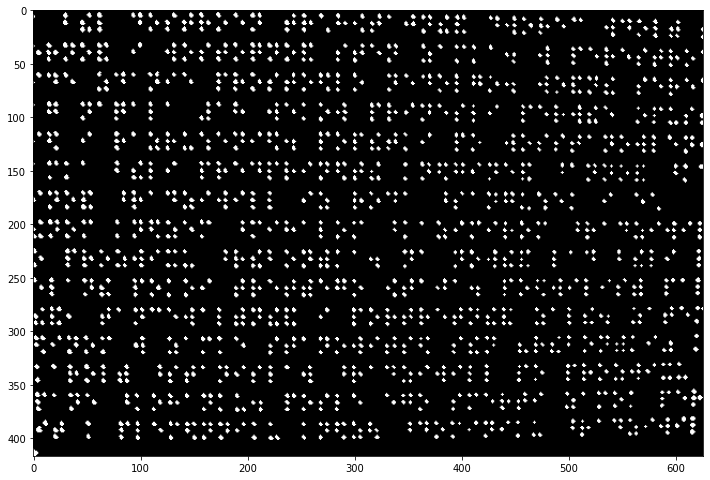

In [2]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagens/placa-braille-com-inscricoes.jpg", 0)
_ , img_bin = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
img_bin = (~img_bin)/255

# Realizando erosão seguida de dilatação para separar pontos conectados
kernel = skimage.morphology.disk(1)
dst_img = cv2.erode( img_bin, kernel, iterations = 1 )
dst_img = cv2.dilate( dst_img, kernel, iterations = 1 )

plt.figure(figsize=(12,12))
plt.imshow(dst_img, cmap='gray')

In [3]:
def make_histogram_y(img):
    '''
    Organiza os dados da projeção horizontal na imagem
    
    Entrada:
    img -> Array da imagem
    
    Saída:
    hist -> Array com os valores do histograma de projeção horizontal
    '''

    height, width = img.shape

    hist = np.zeros(height)
    for x in range(height):
        for y in range(width):
            if (img[x][y] == 1):
                hist[x] += 1
    
    return np.array(hist)

In [4]:
def make_histogram_x(img):
    '''
    Organiza os dados da projeção vertical na imagem
    
    Entrada:
    img -> Array da imagem
    
    Saída:
    hist -> Array com os valores do histograma de projeção vertical
    '''

    height, width = img.shape

    hist = np.zeros(width)
    for x in range(height):
        for y in range(width):
            if (img[x][y] == 1):
                hist[y] += 1
    
    return np.array(hist)

In [5]:
def get_delimiters(hist):
    delimiters = list()
    for i in range(1, len(hist)-1):
        if (hist[i] > 0) and (hist[i-1] == 0) and (hist[i+1] > 0):
            delimiters.append(i-1)
        if (hist[i] > 0) and (hist[i-1] > 0) and (hist[i+1] == 0):
            delimiters.append(i+1)
    return delimiters

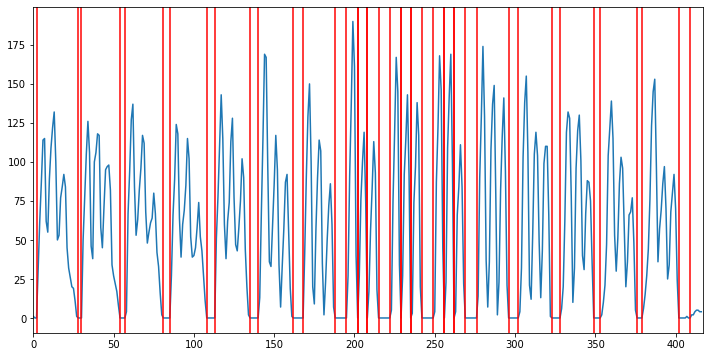

In [6]:
hist_y = make_histogram_y(img_bin)
x = np.arange(len(hist_y))

plt.figure(figsize=(12,6))
plt.plot(x, hist_y)
plt.xlim(0, len(hist_y))

delimiters_y = get_delimiters(hist_y)
for lx in delimiters_y:
    plt.axvline(lx, color='red')

In [7]:
distances_y = list()
for i in range(len(delimiters_y)-1):
    distances_y.append(delimiters_y[i+1] - delimiters_y[i])
    # print(f"{delimiters_y[i+1]} - {delimiters_y[i]}", end='\n')
print(distances_y)
print(f"Menor distância entre as linhas de pontos: {np.min(distances_y)}")
print(f"Distância que mais se repete: {stat.mode(distances_y)}")

[26, 2, 24, 3, 24, 4, 23, 5, 22, 5, 22, 6, 20, 7, 7, 0, 6, 0, 7, 7, 7, 0, 6, 0, 7, 7, 7, 0, 6, 0, 7, 7, 20, 6, 21, 5, 21, 4, 23, 3, 23, 7]
Menor distância entre as linhas de pontos: 0
Distância que mais se repete: 7


In [8]:
def get_line_delimiters(delimiters):

    distances = list()
    for i in range(len(delimiters)-1):
        distances.append(delimiters[i+1] - delimiters[i])
        # print(f"{delimiters[i+1]} - {delimiters[i]}", end='\n')
    distances = np.array(distances)

    min = distances.min() # Distância entre linhas de pontos de um mesmo caractere
    max = distances.max() # Altura de um caractere
    # mode=stat.mode(distances) # Distância 

    line_delimiters = list()
    for i in range(1, len(delimiters)-2):

        if (distances[i] > min+1 and distances[i] < max//2
            and distances[i+1] > min+1 and distances[i-1] > min+1):

            line_delimiters.append(delimiters[i])
            line_delimiters.append(delimiters[i+1])
        if i-1 == 0:
            line_delimiters.append(delimiters[i-1])
        if i+1 == len(delimiters)-2:
            line_delimiters.append(delimiters[i+1])

    return line_delimiters

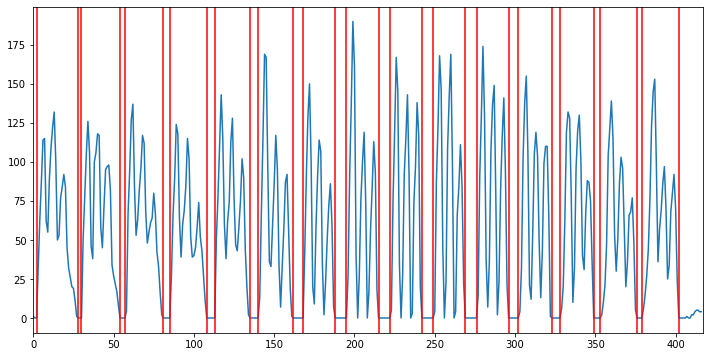

In [9]:
line_delimiters = get_line_delimiters(delimiters_y)

plt.figure(figsize=(12,6))
plt.plot(x, hist_y)
plt.xlim(0, len(hist_y))

for lx in line_delimiters:
    plt.axvline(lx, color='red')
# print(delimiters_y)
# print(line_delimiters)

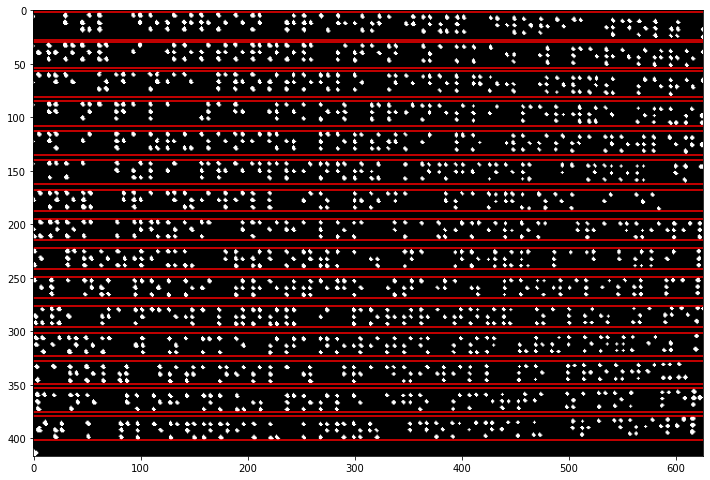

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(dst_img, cmap='gray')

for ly in line_delimiters:
    plt.axhline(ly, color='red')

In [11]:
# Função que recebe uma imagem de texto braille e retorna subimagens com cada
# caractere da imagem
def get_line_subimages(img, line_delimiters):

    line_delimiters = sorted(line_delimiters)
    line_subimages = list()
    for i in range(len(line_delimiters)//2):
        line_subimages.append(img[line_delimiters[2*i]:line_delimiters[2*i+1],:])
    return line_subimages

[2, 28, 30, 54, 57, 81, 85, 108, 113, 135, 140, 162, 168, 188, 195, 215, 222, 242, 249, 269, 276, 296, 302, 323, 328, 349, 353, 376, 379, 402]


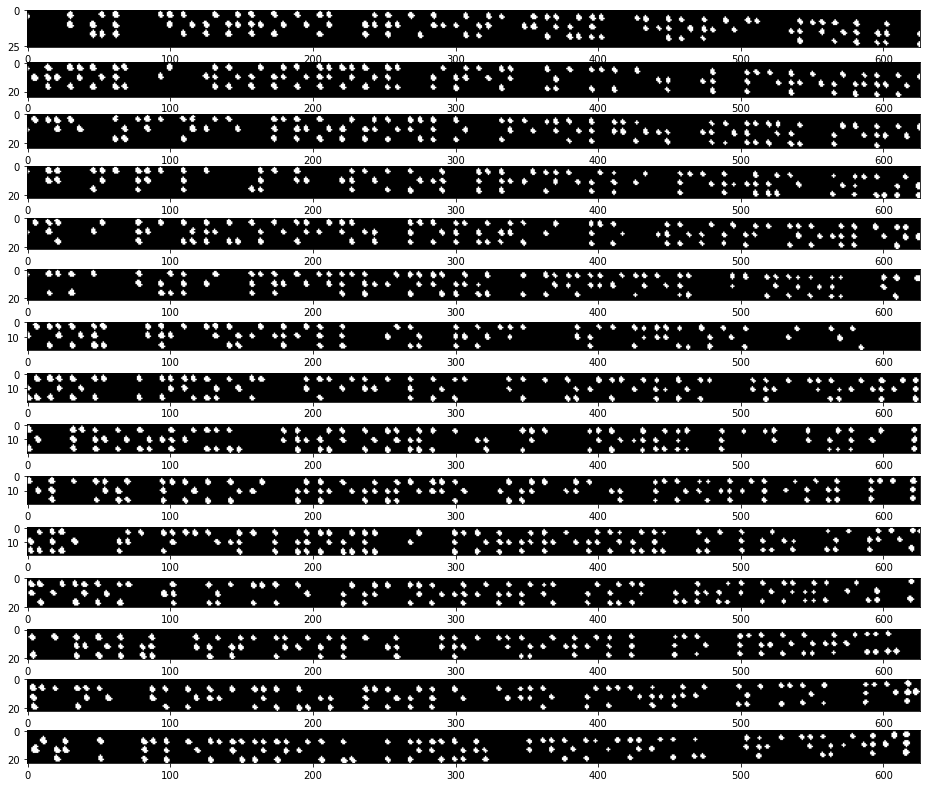

In [12]:
line_subimages = get_line_subimages(dst_img, line_delimiters)
fig, axs = plt.subplots(nrows=len(line_subimages), ncols=1, figsize=(16,14))
for i in range(len(line_subimages)):
    axs[i].imshow(line_subimages[i], cmap='gray')
print(sorted(line_delimiters))

In [13]:
def get_box_x_delimiters(delimiters_x):

    distances = list()
    for i in range(len(delimiters_x)-1):
        distances.append(delimiters_x[i+1] - delimiters_x[i])
        # print(f"{delimiters_x[i+1]} - {delimiters_x[i]}", end='\n')
    distances = np.array(distances)
    min = distances.min()
    mode=stat.mode(distances)

    box_x_delimiters = list()
    for i in range(len(delimiters_x)-1):

        # Delimitando os caracters que possuem pontos nas duas colunas
        diameter = mode
        if (distances[i] <= min+1):
            if i != 0:
                diameter = delimiters_x[i] - delimiters_x[i-1]
            box_x_delimiters.append(delimiters_x[i] - diameter)
            box_x_delimiters.append(delimiters_x[i+1] + diameter)
            
        #Delimitando os caracteres de início e final de linha
        elif i == 0:
            # Caso em que o caractere possui pontos apenas na coluna da esquerda
            if (distances[i+1] > mode+min):
                box_x_delimiters.append(delimiters_x[i+1] + min + mode)
                box_x_delimiters.append(delimiters_x[i])
            # Caso em que o caractere possui pontos apenas na coluna da direita
            else:
                box_x_delimiters.append(delimiters_x[i] - min - mode)
                box_x_delimiters.append(delimiters_x[i+1])

        elif (i == len(distances)-1):
            # Caso em que o caractere possui pontos apenas na coluna da direita
            if (distances[i-1] > mode+min and distances[i-3] > min+1):
                box_x_delimiters.append(delimiters_x[i-1] - min - mode)
                box_x_delimiters.append(delimiters_x[i])
            # Caso em que o caractere possui pontos apenas na coluna da esquerda
            else:
                box_x_delimiters.append(delimiters_x[i+1] + min + mode)
                box_x_delimiters.append(delimiters_x[i])

        # Delimitando os caracteres que possuem pontos apenas na coluna da esquerda
        if (distances[i] > 1.5*mode+min):
            if i > 1 and distances[i-2] > min+1:
                box_x_delimiters.append(delimiters_x[i] + min + mode)
                box_x_delimiters.append(delimiters_x[i-1])
        
        # Delimitando os caracteres que possuem pontos apenas na coluna da direita
        elif ((distances[i] > 1.5*mode+min) and (i < len(delimiters_x)-3) and
            (distances[i+2] > min+1)):
            # if (i < len(delimiters_x)-3) and distances[i+2] > min+1:
                box_x_delimiters.append(delimiters_x[i+2])
                box_x_delimiters.append(delimiters_x[i+1] - min - mode)
            # elif i == len(delimiters_x)-2:
            #     box_x_delimiters.append(delimiters_x[i+2])
            #     box_x_delimiters.append(delimiters_x[i+1] - min - mode)

        # Delimitando os caracteres de espaço em branco
        if (distances[i] >= 3*mode+min):
            box_x_delimiters.append(delimiters_x[i] + mode)
            box_x_delimiters.append(delimiters_x[i+1] - mode)

    return box_x_delimiters

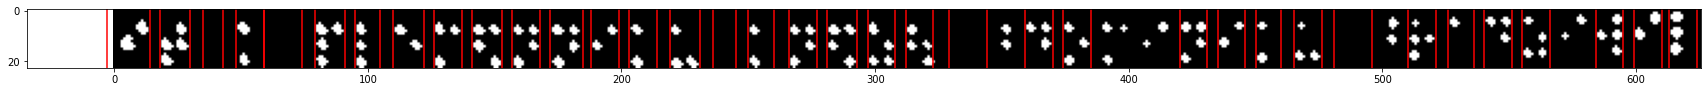

In [14]:
hist_x = make_histogram_x(line_subimages[14])
delimiters_x = get_delimiters(hist_x)
box_x_delimiters = get_box_x_delimiters(delimiters_x)

plt.figure(figsize=(30,24))
plt.imshow(line_subimages[14], cmap='gray')

for lx in box_x_delimiters:
    plt.axvline(lx, color='red')

In [15]:
def get_subimages(img, delim):

    delim = sorted(delim)
    for i in range(len(delim)):
        if delim[i] < 0:
            delim[i] = 0
    subimages = list()
    for i in range(len(delim)//2):
        subimages.append(img[:, delim[2*i]:delim[2*i+1]])
    return subimages

35


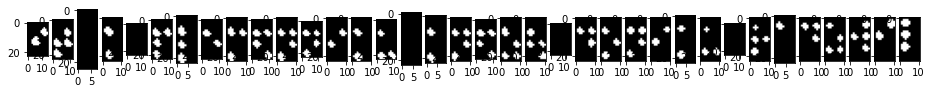

In [16]:
subimages = get_subimages(line_subimages[14], box_x_delimiters)
fig, axs = plt.subplots(nrows=1, ncols=len(subimages), figsize=(16,14))
for i in range(len(subimages)):
    axs[i].imshow(subimages[i], cmap='gray')
print(i)